# 코로나 19 시계열 데이터
----------

    
## 컬럼 명


    Country/Region: 국가
    Province/State: 지방/주
    Lat: 지역의 위도
    Long: 지역의 경도
    날짜: 각 날짜의 확진자/사망자 수
    
    
    
- 데이터 출처: https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university


# 데이터 및 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
df_case = pd.read_csv('/content/drive/MyDrive/study/Kaggle/코로나19 분석/covid19/RAW_global_confirmed_cases.csv')
df_death = pd.read_csv('/content/drive/MyDrive/study/Kaggle/코로나19 분석/covid19/RAW_global_deaths.csv')

In [4]:
df_case.head(3)

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21
0,Afghanistan,NaN,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,48718,48952,49161,49378,49621,49681,49817,50013,50190,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207,53332,53400,53489,53538,53584,53584,53775,53831,53938,53984,54062,54141,54278,54403,54483
1,Albania,NaN,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,49191,50000,50637,51424,52004,52542,53003,53425,53814,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705,62378,63033,63595,63971,64627,65334,65994,66635,67216,67690,67982,68568,69238,69916,70655
2,Algeria,NaN,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,92597,93065,93507,93933,94371,94781,95203,95659,96069,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382,101657,101913,102144,102369,102641,102860,103127,103381,103611,103833,104092,104341,104606,104852,105124


In [5]:
df_death.head(3)

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21
0,Afghanistan,NaN,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1969,1995,2011,2025,2030,2047,2067,2082,2096,2117,2126,2139,2149,2160,2174,2179,2181,2191,2191,2191,2191,2237,2244,2244,2253,2257,2264,2277,2288,2301,2301,2314,2324,2336,2339,2343,2346,2354,2363,2370
1,Albania,NaN,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1016,1028,1040,1055,1066,1074,1088,1098,1111,1117,1125,1134,1143,1153,1164,1170,1174,1181,1181,1190,1193,1199,1210,1217,1223,1230,1233,1241,1247,1252,1256,1261,1265,1270,1277,1281,1287,1291,1296,1303
2,Algeria,NaN,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2609,2623,2631,2640,2647,2659,2666,2675,2687,2696,2705,2716,2722,2728,2737,2745,2751,2756,2762,2769,2772,2777,2782,2786,2792,2798,2803,2807,2812,2816,2819,2822,2827,2831,2836,2840,2843,2849,2853,2856


# 데이터 정리(구조 변경)


In [31]:
df_case['Country/Region'].value_counts()

China             34
Canada            16
United Kingdom    12
France            12
Australia          8
                  ..
Albania            1
Gabon              1
Costa Rica         1
Tonga              1
Morocco            1
Name: Country/Region, Length: 196, dtype: int64

## 데이터프레임 구조를 Date를 Index로, 지역을 Column으로 변경


In [32]:
def fix_dataframe(df):
  # TODO: 불필요한 컬럼 제거, Date를 datetime 객체로 변환, Date를 index로 변경
  df = df.drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum()
  df = df.transpose()
  df.index.name = 'Date'
  df.reset_index(inplace=True)
  df['Date'] = df['Date'].apply(lambda s: pd.to_datetime(str(s)))
  df.set_index('Date', inplace=True)
  return df

In [33]:
df_case = fix_dataframe(df_case)
df_death = fix_dataframe(df_death)

In [34]:
df_case.tail(3)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Summer Olympics 2020,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Tonga,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-25,160252,248859,241406,34701,97594,6023,8041520,353731,2340046,1650597,636956,32238,338524,1715997,40632,730207,2878212,48263,26309,3951,828232,336680,245904,24342322,16148,903676,20514,534383,37138,55471,121094,114113,2960588,13840,7075,2001346,119009,5780910,7814,23485,...,7607,322770,1478543,624851,650,25388,3585888,16738,9395767,603654,55833,865,71629,1922990,2003262,51075,18411,17609,32920,2398944,19871,36372,1,107408,856739,11090493,72257016,160778,4075351,830832,16158455,609785,216186,7,471389,2171527,488599,10585,302569,228776
2022-01-26,160692,251015,243568,35028,97812,6442,8130023,355662,2391062,1684608,640148,32282,343400,1731524,41355,732104,2939439,49059,26450,4089,835170,339281,245904,24560093,16179,913592,20591,534503,37170,55543,121116,114113,2966448,13840,7075,2020082,119152,5798799,7821,23485,...,7608,327602,1494945,642342,676,25388,3590399,16752,9529320,604581,56595,865,72088,1973485,2046465,51124,18503,17627,32920,2407022,19879,36421,1,108088,866445,11167927,72910136,160974,4100292,833201,16260882,621453,217360,7,475135,2187481,492694,10821,303266,228943
2022-01-27,161004,252577,245698,35028,97901,6524,8207752,358218,2457285,1727661,643509,32376,348655,1747331,42122,734078,3007724,49794,26450,4225,841757,341913,250746,24789795,16206,923466,20591,534671,37265,55595,121150,114113,2997728,13898,7075,2045874,119404,5816462,7824,23653,...,7611,333071,1512072,656569,755,25388,3594499,16767,9660208,607104,57106,865,72548,2015276,2091306,51177,18566,17639,32920,2415472,19894,36452,1,108892,876245,11250107,73427335,161259,4133396,835839,16358047,631019,218477,7,477022,2203208,500444,10888,304002,229096


# EDA

##  확진자 수 상위 10개국 사망자 수 시각화


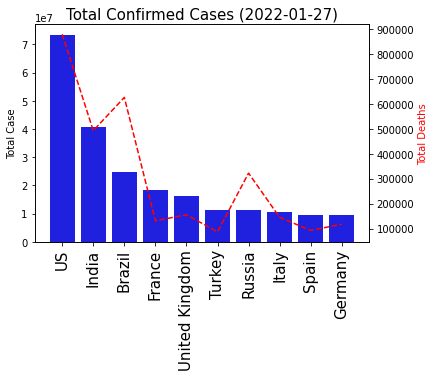

In [61]:
top_ten_cases = df_case.loc[df_case.index[-1]].sort_values(ascending=False)[:10] # 상위 10개국
sns.barplot(x=top_ten_cases.index, y=top_ten_cases, color='blue')

plt.xticks(rotation=90, size=15)
plt.ylabel('Total Case')
plt.xlabel('')
plt.title('Total Confirmed Cases (%s)' % top_ten_cases.name.strftime('%Y-%m-%d'), size=15)

ax = plt.gca()
ax2 = ax.twinx()

top_ten_deaths = df_death.loc[df_death.index[-1]][top_ten_cases.index]
ax2.plot(top_ten_deaths.index, top_ten_deaths, 'r--')

ax2.set_ylabel('Total Deaths', color='red')

plt.show()

## 국가 별 확진자 수 및 사망자 수 시각화

In [62]:
## 누적 확진자/사망자 수
def plot_case_with_death(country):
  plt.figure(figsize=(6,6))
  plt.plot(df_case.index, df_case[country], 'b-')
  plt.title(country)
  plt.ylabel('Confirmed Cases', color='blue')
  plt.xlabel('Date')
  plt.xlim(right=df_case.index[-1])
  plt.ylim(0, df_case[country].max()*1.1)

  ax = plt.gca()
  ax2 = ax.twinx()
  ax2.plot(df_death.index, df_death[country], 'r--')
  ax2.set_xlabel('Deaths', color='red')
  ax2.set_ylim(0, df_death[country].max()*1.1)
  plt.show()

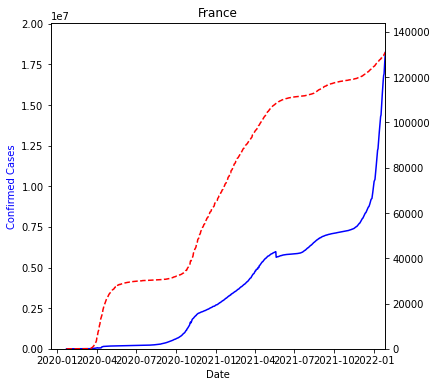

In [63]:
plot_case_with_death('France')

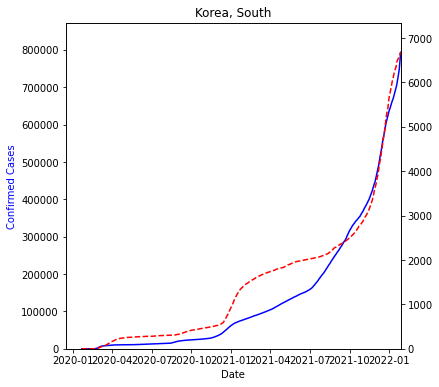

In [64]:
plot_case_with_death('Korea, South')

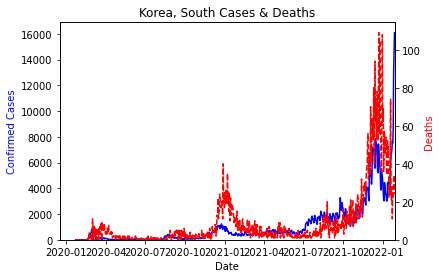

In [65]:
## 일일 확진자 수
country = 'Korea, South'
plt.plot(df_case.index, df_case[country].diff(), 'b-')
plt.ylabel('Confirmed Cases', color='blue')
plt.title(country + ' Cases & Deaths')
plt.xlabel('Date')
plt.xlim(right=df_case.index[-1])
plt.ylim(bottom=0)

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df_death.index, df_death[country].diff(), 'r--')
ax2.set_ylabel('Deaths', color='red')
ax2.set_ylim(bottom=0)
plt.show()

# Plotly를 이용한 데이터 시각화

In [66]:
import plotly.graph_objects as go

In [87]:
# 국가명을 국가코드로 변경
df_code = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

country_renamer = {
    'Taiwan*':'Taiwan',
    'US':'United States',
}

In [70]:
df_code.head()

,COUNTRY,GDP (BILLIONS),CODE
0,Afghanistan,21.71,AFG
1,Albania,13.40,ALB
2,Algeria,227.80,DZA
3,American Samoa,0.75,ASM
4,Andorra,4.80,AND


In [88]:
# 시각화를 위한 데이터 칼럼 명 변경
country_to_code = df_code.set_index('COUNTRY')['CODE']
country_to_code.head()

COUNTRY
Afghanistan       AFG
Albania           ALB
Algeria           DZA
American Samoa    ASM
Andorra           AND
Name: CODE, dtype: object

In [89]:
# 시각화를 위한 데이터 칼럼 명 변경 작업중
df_c = df_case.rename(country_renamer, axis=1).copy()
for col in df_c.columns:
  if col not in country_to_code.index:
    df_c.drop(col, axis=1, inplace=True)
df_code = df_c.rename(country_to_code, axis=1)

df_code.head()

Country/Region,AFG,ALB,DZA,AND,AGO,ATG,ARG,ARM,AUS,AUT,AZE,BHR,BGD,BRB,BLR,BEL,BLZ,BEN,BTN,BOL,BIH,BWA,BRA,BRN,BGR,BFA,MMR,BDI,CPV,KHM,CMR,CAN,CAF,TCD,CHL,CHN,COL,COM,CRI,CIV,...,SRB,SYC,SLE,SGP,SVK,SVN,SLB,SOM,ZAF,SSD,ESP,LKA,SDN,SUR,SWE,CHE,SYR,TWN,TJK,TZA,THA,TLS,TGO,TON,TTO,TUN,TUR,USA,UGA,UKR,ARE,GBR,URY,UZB,VUT,VEN,VNM,YEM,ZMB,ZWE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,6,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,8,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0


In [90]:
def get_choropleth_data(date):
  data = go.Choropleth(
      locations = df_code.columns,
      z = df_code.loc[date],
      text = df_c.columns,
      colorscale = 'Blues',
      autocolorscale=False,
      reversescale=False,
      marker_line_color='darkgray',
      marker_line_width=0.5,
      colorbar_tickprefix = '',
      colorbar_title = 'Confirmed Cases',
  )
  return data

In [91]:
date = df_case.index[-1]
data = get_choropleth_data(date)
fig = go.Figure(data=data)
fig.update_layout(
    title_text='Confirmed Cases in ' + str(date),
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

# 데이터 전처리 

In [92]:
# FBProphet 학습을 위해 데이터 구조 변경
df = pd.DataFrame(df_case.reset_index()[['Date', 'Korea, South']].to_numpy(), columns=['ds', 'y'])
df.head()

,ds,y
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3


# 학습데이터와 테스트데이터 분리


In [93]:
from math import floor

In [97]:
def train_test_split_df(df, test_size):
  div = floor(df.shape[0] * (1-test_size))
  return df.loc[:div], df.loc[div+1:]

In [98]:
train_df, test_df = train_test_split_df(df, 0.1)

In [99]:
(train_df.shape , test_df.shape)

((664, 2), (73, 2))

# Prophet 모델 생성 및 학습

In [100]:
from fbprophet import Prophet

In [104]:
model = Prophet(changepoint_range=1.0)
model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Prophet 모델 학습 결과 시각화

In [102]:
from fbprophet.plot import add_changepoints_to_plot

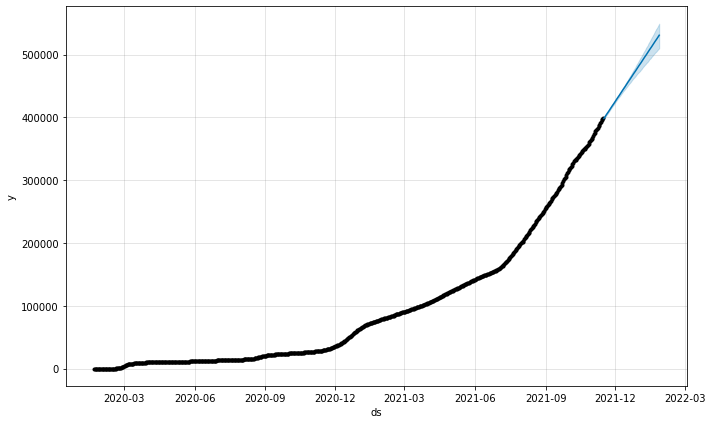

In [105]:
pred = model.predict(test_df)

model.plot(pred);

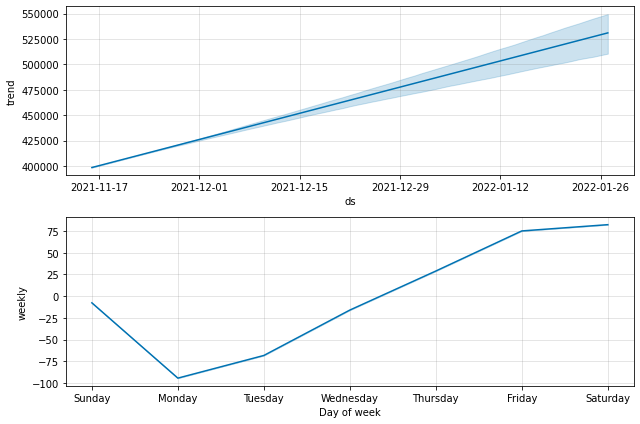

In [106]:
model.plot_components(pred);

일요일 -> 월요일은 감소하나 그 이후부터 토요일까지는 증가하는 경향

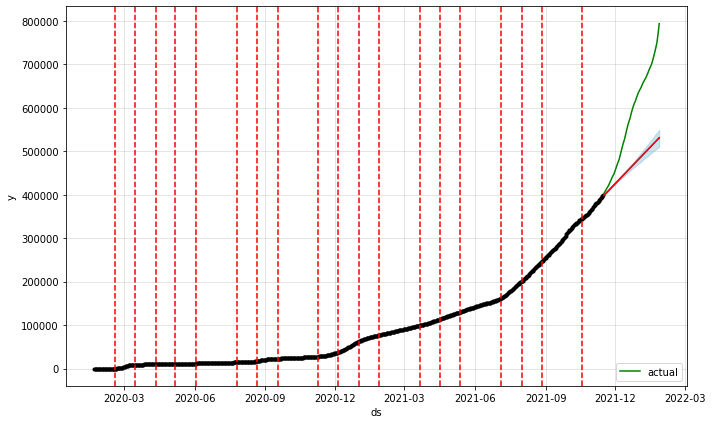

In [107]:
fig = model.plot(pred)
plt.plot(test_df['ds'], test_df['y'], 'g-', label='actual')
add_changepoints_to_plot(fig.gca(), model, pred)
plt.legend()

# 모델 학습 결과 평가

In [108]:
from sklearn.metrics import r2_score

In [110]:
print('R2 Score: ', r2_score(test_df['y'], pred['yhat']))

R2 Score:  -0.47188070055690545


# 미래 30일 데이터 예측

전체 df를 학습한 후, 향후 30일에 대한 데이터 예측

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


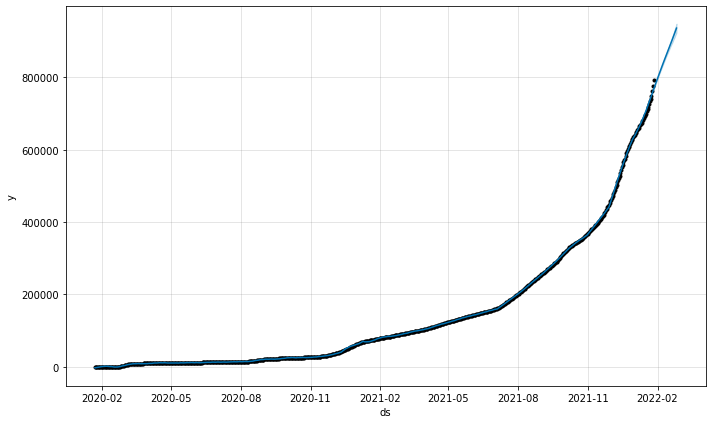

In [112]:
model = Prophet(changepoint_range=1.0)
model.fit(df)

future = model.make_future_dataframe(30)
pred = model.predict(future)
model.plot(pred);

# IF-CASE 예측


## 한국 확진자 수 변화의 특별한 이벤트 확인


In [113]:
# 코로나 확산 초기, 한국의 확진자 수가 급증한 시점 찾기
df.loc[:30]

,ds,y
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3
5,2020-01-27,4
6,2020-01-28,4
7,2020-01-29,4
8,2020-01-30,4
9,2020-01-31,11


## 이벤트가 없었을 경우 한국의 확진자 수 변화 예측


확진자 수가 급증하기 전 데이터를 학습 후, 해당 시점으로부터 30일 간의 데이터 예측하여 실제 값과 비교

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


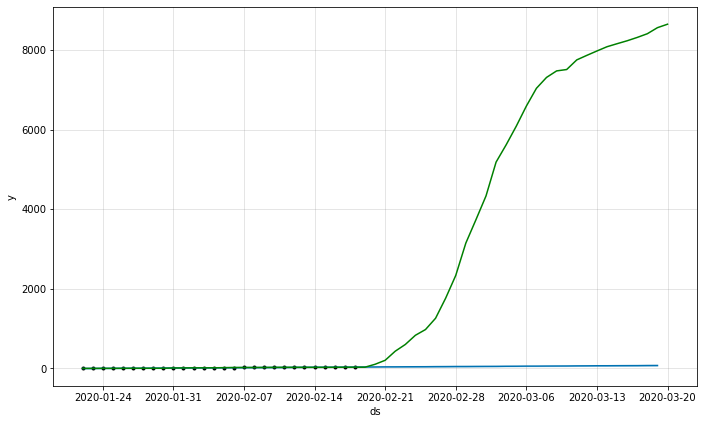

In [114]:
model = Prophet(changepoint_range=1.0)
model.fit(df[:28])

future = model.make_future_dataframe(30)
pred = model.predict(future)

model.plot(pred);
plt.plot(df.loc[:58]['ds'], df.loc[:58]['y'], 'g-')
plt.show()